Contoh Model dari https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

---------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np

import os
import pathlib
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.utils import np_utils, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# creating Dataframe using all the 4 dataframes we created so far.
path = pathlib.Path("Dataset") / "data"
data_dict = {
    "paths":[],
    "labels":[],
}
for audio_path in path.glob("*/*"):
    label = str(audio_path).split(os.sep)[-2]
    data_dict["paths"].append(audio_path)
    data_dict["labels"].append(label)

data_path = pd.DataFrame(data_dict)
data_path.to_csv("data_path_v2.csv",index=False)
data_path.head()

,paths,labels
0,Dataset\data\angry\03-01-05-01-01-01-01.wav,angry
1,Dataset\data\angry\03-01-05-01-01-01-02.wav,angry
2,Dataset\data\angry\03-01-05-01-01-01-03.wav,angry
3,Dataset\data\angry\03-01-05-01-01-01-04.wav,angry
4,Dataset\data\angry\03-01-05-01-01-01-05.wav,angry


In [3]:
emotions = os.listdir(pathlib.Path("Dataset") / "data")
emotions

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

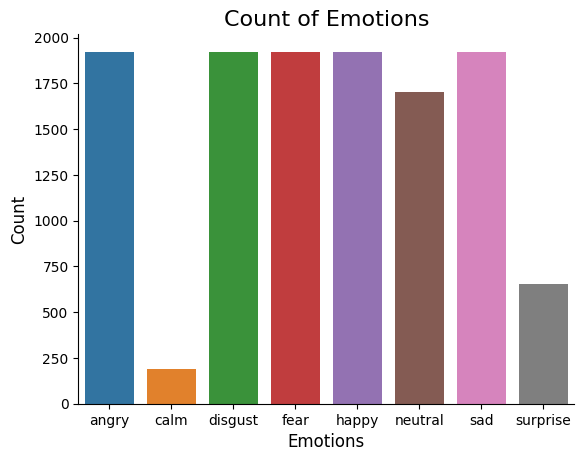

In [4]:
data_path['labels'] = data_path['labels'].astype('category')
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='labels')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [6]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    # return librosa.effects.pitch_shift(data, sr=sampling_rate, pitch_factor)
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [7]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = librosa.feature.zero_crossing_rate(y=data)
    zcr_mean = np.mean(zcr, axis=1)
    zcr_min = np.min(zcr, axis=1)
    zcr_max = np.max(zcr, axis=1)
    zcr_feature = np.concatenate((zcr_min, zcr_mean, zcr_max))

    # Chroma_stft
    # stft = np.abs(librosa.stft(data))
    
    chroma_stft = librosa.feature.chroma_stft(S=librosa.stft(data), sr=sample_rate)
    chroma_stft_mean = np.mean(chroma_stft, axis=1)
    chroma_stft_min = np.min(chroma_stft, axis=1)
    chroma_stft_max = np.max(chroma_stft, axis=1)
    chroma_stft_feature = np.concatenate((chroma_stft_min, chroma_stft_mean, chroma_stft_max))

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_min = np.min(mfcc, axis=1)
    mfcc_max = np.max(mfcc, axis=1)
    mfcc_feature = np.concatenate((mfcc_min, mfcc_mean, mfcc_max))

    # Root Mean Square Value
    # rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    # result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    mel_mean = np.mean(mel, axis=1)
    mel_min = np.min(mel, axis=1)
    mel_max = np.max(mel, axis=1)
    mel_feature = np.concatenate((mel_min, mel_mean, mel_max))
    
    result = np.concatenate((zcr_feature, chroma_stft_feature, mfcc_feature, mel_feature))
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [8]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [9]:
def get_Features_Dataframe(csv='features_v2.csv'):
    try:
        return pd.read_csv(csv)
    except:
        print("Dataframe not found. Dataframe will be created. Please wait until the program is finished")
    X, Y = [], []
    numOfSongsPath = data_path.shape[0]
    num = 0
    # Initial call to print 0% progress
    printProgressBar(0, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = 'Complete', length = 50)
    for path, emotion in zip(data_path.paths, data_path.labels):
        num += 1
        feature = get_features(path)
        l = len(feature)
        for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        printProgressBar(num, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = f'{str(path)[:20]}... Complete', length = 50)
    Features = pd.DataFrame(X)
    Features['labels'] = Y
    Features.to_csv(csv, index=False)
    return Features
        

In [11]:
Features = get_Features_Dataframe(csv='features_v2.csv')

In [12]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
X

array([['(0.021484375+0j)', '(0.2153908058449074+0j)',
        '(0.8466796875+0j)', ..., '(0.009701820090413094+0j)',
        '(0.007742794696241617+0j)', '(0.00034039089223369956+0j)'],
       ['(0.0400390625+0j)', '(0.24638762297453703+0j)',
        '(0.521484375+0j)', ..., '(0.010250222247534068+0j)',
        '(0.007926047675621694+0j)', '(0.00043591614046098237+0j)'],
       ['(0.03955078125+0j)', '(0.17739800347222223+0j)', '(0.5+0j)',
        ..., '(0.00034520539338700473+0j)', '(0.0001455834717489779+0j)',
        '(8.906293078325689e-05+0j)'],
       ...,
       ['(0.01416015625+0j)', '(0.0917202818627451+0j)',
        '(0.38623046875+0j)', ..., '(0.00035567962913773954+0j)',
        '(0.00047881671343930066+0j)', '(1.0143921826966107e-05+0j)'],
       ['(0.02978515625+0j)', '(0.12155330882352941+0j)',
        '(0.4794921875+0j)', ..., '(0.0005929124405620816+0j)',
        '(0.0005889727185627246+0j)', '(0.0004009087196465581+0j)'],
       ['(0.0166015625+0j)', '(0.107315063476

In [13]:
len(X), len(Y), data_path.labels.shape

(36486, 36486, (12162,))

In [31]:
def extract_tonnetz_features(data, sample_rate):
    tonnetz = librosa.feature.tonnetz(y=data, sr=sample_rate)
    tonnetz_mean = np.mean(tonnetz, axis=1)
    tonnetz_min = np.min(tonnetz, axis=1)
    tonnetz_max = np.max(tonnetz, axis=1)
    return np.concatenate((tonnetz_min, tonnetz_mean, tonnetz_max))
    

def get_tonnetz_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_tonnetz_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_tonnetz_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_tonnetz_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result
def add_tonnetz_features(X) :
    tonnetz_feature = []
    numOfSongsPath = data_path.shape[0]
    num = 0
    # Initial call to print 0% progress
    printProgressBar(0, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = 'Complete', length = 50)
    for path, emotion in zip(data_path.paths, data_path.labels):
        num += 1
        feature = get_tonnetz_features(path)
        l = len(feature)
        for ele in feature:
            tonnetz_feature.append(ele)
        printProgressBar(num, numOfSongsPath, prefix = f'Progress ({num}/{numOfSongsPath}):', suffix = f'{str(path)[:20]}... Complete', length = 50)
    return np.concatenate((X, np.array(tonnetz_feature)), axis=1)

In [29]:
zeros = np.zeros((len(X), 5))
ones = np.ones((len(X), 1))
np.concatenate((ones, zeros), axis = 1)


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [14]:
# As this is a multiclass classification problem onehotencoding our Y.
# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
for i in range(X.shape[0]):
    X[i] = np.array(list(map(lambda x: eval(x), X[i]))).real
X

array([[0.021484375, 0.2153908058449074, 0.8466796875, ...,
        0.009701820090413094, 0.007742794696241617,
        0.00034039089223369956],
       [0.0400390625, 0.24638762297453703, 0.521484375, ...,
        0.010250222247534068, 0.007926047675621694,
        0.00043591614046098237],
       [0.03955078125, 0.17739800347222223, 0.5, ...,
        0.00034520539338700473, 0.0001455834717489779,
        8.906293078325689e-05],
       ...,
       [0.01416015625, 0.0917202818627451, 0.38623046875, ...,
        0.00035567962913773954, 0.00047881671343930066,
        1.0143921826966107e-05],
       [0.02978515625, 0.12155330882352941, 0.4794921875, ...,
        0.0005929124405620816, 0.0005889727185627246,
        0.0004009087196465581],
       [0.0166015625, 0.1073150634765625, 0.39111328125, ...,
        0.0006192887085489929, 0.00015031314978841692,
        3.2854482014954556e-06]], dtype=object)

In [32]:
new_X = add_tonnetz_features(X)

Progress (12162/12162): |██████████████████████████████████████████████████| 100.0% Dataset\data\surpris... Complete


In [34]:
new_X.shape

(36486, 501)

In [40]:
# splitting data
x_train, x_val_test, y_train, y_val_test = train_test_split(np.asarray(new_X).astype('float64'), Y, random_state=123, shuffle=True, stratify=Y, test_size=0.25)
x_test, x_val, y_test, y_val = train_test_split(x_val_test, y_val_test, random_state=123, shuffle=True, stratify=y_val_test, test_size=0.5)
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape


((27364, 501), (27364,), (4561, 501), (4561,), (4561, 501), (4561,))

In [74]:
# x_train = np.expand_dims(x_train, axis=2)
# x_val = np.expand_dims(x_val, axis=2)
# x_test = np.expand_dims(x_test, axis=2)

In [42]:
label= y_train[0]
np.argmax(label == np.array(emotions))
np.array(emotions) == label

False

In [41]:
mapper = lambda label: np.argmax(label == np.array(emotions))
y_train = np.array(list(map(mapper, y_train)))
y_val = np.array(list(map(mapper, y_val)))
y_test = np.array(list(map(mapper, y_test)))

In [43]:
max(y_train)

7

In [44]:
num_labels = len(emotions)
input_shape = (x_train.shape[1],)
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
norm_layer.adapt(data=np.squeeze(x_train))

model = Sequential([
    keras.layers.Input(shape=input_shape),
    norm_layer,
    Dense(500, activation="relu"),
    Dropout(0.25),
    Dense(300, activation="relu"),
    Dropout(0.2),
    Dense(100, activation="relu"),
    Dense(num_labels)
])
model.summary()

Input shape: (501,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 501)              1003      
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 500)               251000    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 300)               150300    
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               30100     
                                  

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 100
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=1e-15)
history = model.fit(
    # train_ds,
    np.squeeze(x_train), y_train,
    # validation_data=val_ds,
    validation_data=(np.squeeze(x_val), y_val),
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
    callbacks=[rlrp]
)

Epoch 1/100
856/856 [==============================] - 13s 13ms/step - loss: 0.2551 - accuracy: 0.9131 - val_loss: 1.1235 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 2/100
856/856 [==============================] - 11s 13ms/step - loss: 0.2627 - accuracy: 0.9104 - val_loss: 1.1224 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 3/100
856/856 [==============================] - 10s 12ms/step - loss: 0.2701 - accuracy: 0.9038 - val_loss: 1.0564 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 4/100
856/856 [==============================] - 11s 12ms/step - loss: 0.2002 - accuracy: 0.9301 - val_loss: 1.0637 - val_accuracy: 0.7218 - lr: 4.0000e-04
Epoch 5/100
856/856 [==============================] - 11s 13ms/step - loss: 0.1703 - accuracy: 0.9399 - val_loss: 1.0637 - val_accuracy: 0.7281 - lr: 4.0000e-04
Epoch 6/100
856/856 [==============================] - 10s 12ms/step - loss: 0.1625 - accuracy: 0.9419 - val_loss: 1.0958 - val_accuracy: 0.7305 - lr: 4.0000e-04
Epoch 7/100
856/856 [===================

In [53]:
saved_model_path = os.path.join("models", "v2.2")
model.save(saved_model_path)

INFO:tensorflow:Assets written to: models\v2.2\assets


INFO:tensorflow:Assets written to: models\v2.2\assets


143/143 [==============================] - 1s 5ms/step - loss: 1.2564 - accuracy: 0.7389
Accuracy of our model on test data :  73.88730645179749 %


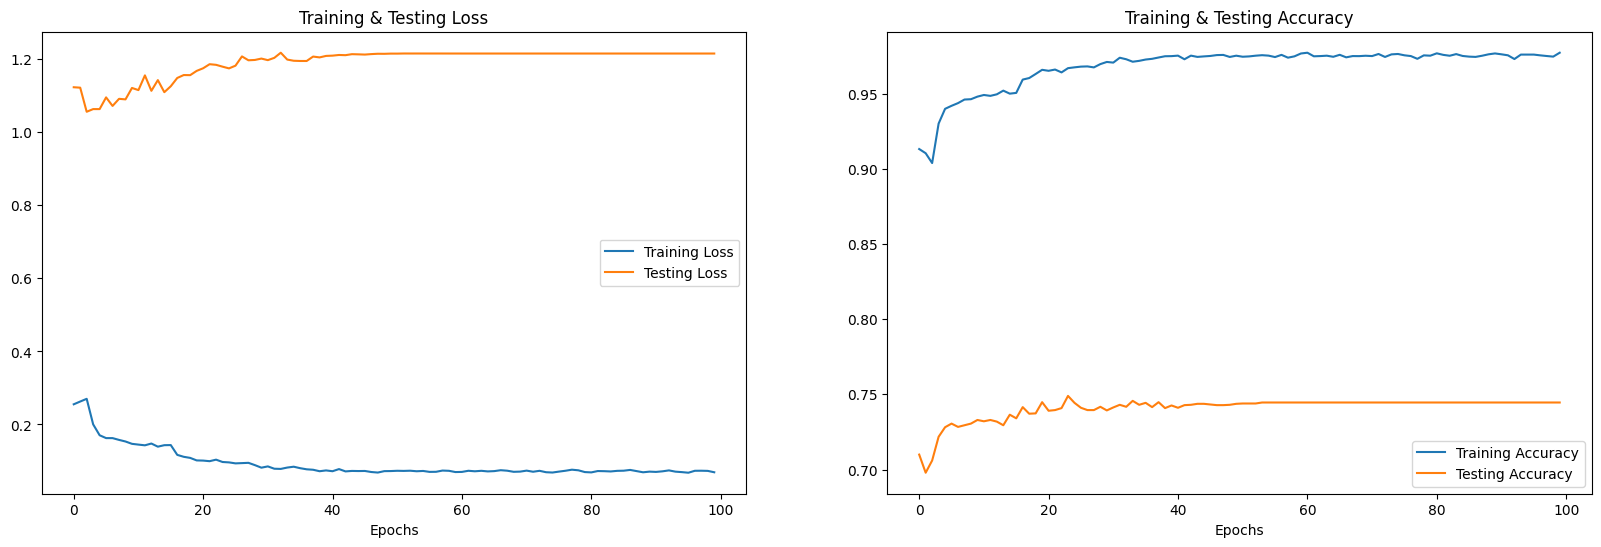

In [54]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [55]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

143/143 [==============================] - 1s 5ms/step
Test set accuracy: 74%


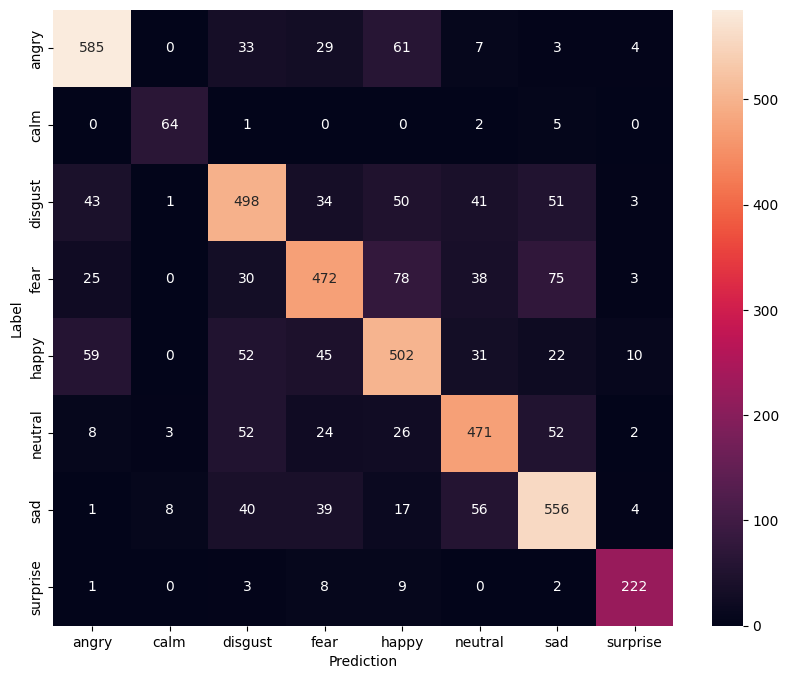

In [56]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=emotions,
            yticklabels=emotions,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [90]:
def process_audio_to_predict(path):
    data, sr = librosa.load(path, duration=2.5)
    return np.concatenate((extract_features(data, sr), extract_tonnetz_features(data, sr))).real
def predict_audio(audio_features):
    emotions = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    return emotions[np.argmax(model.predict(np.expand_dims(audio_features,0)), axis=1)[0]]
    

16/16 [==============================] - 0s 5ms/step
path: Dataset\data\happy\1030_TSI_HAP_XX.wav 
label actually: happy 
label predicted: happy


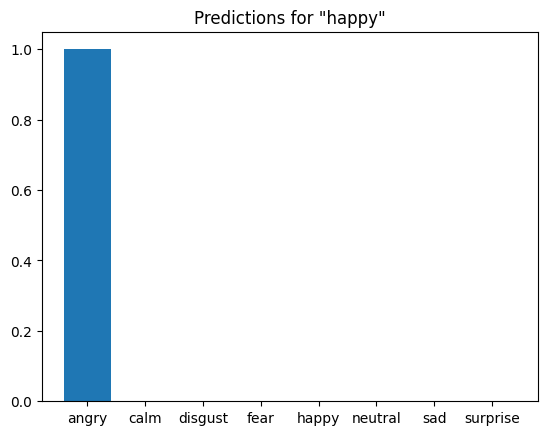

In [95]:
import random
test_index = random.randint(0, data_path.shape[0])
path = data_path.paths[test_index]
label = data_path.labels[test_index]
audio_features = process_audio_to_predict(path)
print(f"path: {path} \nlabel actually: {label} \nlabel predicted: {predict_audio(audio_features)}")
prediction = model(audio_features)
plt.bar(emotions, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for "{label}"')
plt.show()

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       722
           1       0.84      0.89      0.86        72
           2       0.70      0.69      0.70       721
           3       0.73      0.65      0.69       721
           4       0.68      0.70      0.69       721
           5       0.73      0.74      0.73       638
           6       0.73      0.77      0.75       721
           7       0.90      0.91      0.90       245

    accuracy                           0.74      4561
   macro avg       0.76      0.77      0.77      4561
weighted avg       0.74      0.74      0.74      4561



---------------------------------------------------------------------------------------------------------------

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e3e1d63-2a55-4dcb-8826-d15658c6a54b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>